# Contextual Bandits for Adaptive Notification Timing
**Author:** Aarav Singla

**Project Type:** Health Intervention Simulation / Reinforcement Learning

## 1. Configuration and Reproducibility
In this section, we establish the hyperparameters for the **LinUCB (Linear Upper Confidence Bound)** algorithm.
* **`ALPHA`**: This parameter controls the **exploration-exploitation trade-off**. A higher value encourages the agent to explore actions with high uncertainty (lesser known times of day), while a lower value encourages exploiting currently known "best" times.
* **`DIM`**: The dimensionality of the context vector, simulating user features such as current stress level, location context, or recent app usage history.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set seed for reproducibility (Important for research code!)
np.random.seed(42)

# Configuration
N_TRIALS = 2000  # Number of interactions (e.g., notifications sent)
N_ARMS = 4       # Options: Morning, Afternoon, Evening, No_Notification
ALPHA = 2.5      # Exploration parameter (Standard LinUCB hyperparameter)
DIM = 5          # Number of context features (Mood, Stress, Location, etc.)

## 2. The Simulated Health Environment
We model a "Virtual Patient" to serve as our environment. In a real-world health scenario, we cannot know a user's true preference for receiving notifications (the "ground truth").

Here, we simulate this by assigning random **latent preference vectors** (`true_theta`) to the user. The reward signal (clicking a notification) is stochastic (probabilistic), modeled as a **Bernoulli trial** via a sigmoid function. This mimics real human behavior: even at the perfect time, a user might not always click, introducing noise that the agent must robustly handle.

In [2]:
class HealthEnvironment:
    def __init__(self, n_arms, n_features):
        self.n_arms = n_arms
        self.n_features = n_features
        # We generate random "true" preferences for the user that the agent must learn
        # Each arm (time of day) has a specific weight vector
        self.true_theta = np.random.normal(0, 1, (n_arms, n_features))

    def get_context(self):
        # Simulate user state: [Mood, Stress, Busy_Level, Recent_Activity, Time_Encoding]
        return np.random.normal(0, 1, self.n_features)

    def get_reward(self, arm_idx, context):
        # Calculate probability of user clicking based on "Hidden" preferences
        # Sigmoid function to bind reward between 0 and 1 (Bernoulli reward)
        logit = np.dot(self.true_theta[arm_idx], context) + np.random.normal(0, 0.1)
        prob = 1 / (1 + np.exp(-logit))

        # Return 1 (Clicked) or 0 (Ignored)
        return 1 if np.random.rand() < prob else 0

## 3. The LinUCB Agent
This class implements the **Disjoint LinUCB Algorithm**. Unlike standard Multi-Armed Bandits (MAB) which ignore context, this agent assumes the expected reward for an arm is a linear function of the current context.

For each arm $a$, we maintain a matrix $A_a$ (covariance) and vector $b_a$ (reward history). The agent selects the action with the highest Upper Confidence Bound:

$$a_t = \text{argmax}_{a} \left( \hat{\theta}_a^T x_t + \alpha \sqrt{x_t^T A_a^{-1} x_t} \right)$$

* **First Term ($\hat{\theta}_a^T x_t$):** The estimated reward (Exploitation).
* **Second Term (Square Root):** The uncertainty variance (Exploration).

In [3]:
class LinUCBAgent:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.alpha = alpha

        # Initialize A (covariance matrix) and b (reward vector) for each arm
        # A is Identity matrix initially, b is zeros
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def select_action(self, context):
        p_t = np.zeros(self.n_arms)

        for a in range(self.n_arms):
            # Theta_hat = A_inv * b (Ridge Regression solution)
            A_inv = np.linalg.inv(self.A[a])
            theta_hat = np.dot(A_inv, self.b[a])

            # UCB calculation: Prediction + Exploration Bonus
            uncertainty = self.alpha * np.sqrt(np.dot(context.T, np.dot(A_inv, context)))
            p_t[a] = np.dot(theta_hat.T, context) + uncertainty

        # Tie-breaking: random choice among max values
        return np.random.choice(np.flatnonzero(p_t == p_t.max()))

    def update(self, arm, context, reward):
        # Update matrix A and vector b for the chosen arm
        self.A[arm] += np.outer(context, context)
        self.b[arm] += reward * context

## 4. Simulation Loop and Regret Calculation
We run the simulation for `N_TRIALS` iterations. In every step, the system:
1.  **Observes Context:** The user's current state (e.g., "High Stress").
2.  **Takes Action:** The agent selects a notification time.
3.  **Receives Reward:** The environment returns 1 (Engagement) or 0 (Ignore).
4.  **Updates Beliefs:** The agent performs a Ridge Regression update on $A$ and $b$.

To evaluate performance, we calculate **Regret**: the difference between the probability of reward from the *optimal* action and the *chosen* action.

In [4]:
# Initialize
env = HealthEnvironment(N_ARMS, DIM)
agent = LinUCBAgent(N_ARMS, DIM, ALPHA)

aligned_rewards = []
rewards_history = []
regret_history = []

for t in range(N_TRIALS):
    # 1. Observe Context (e.g., User is stressed)
    context = env.get_context()

    # 2. Agent picks Action (e.g., Send Evening Notification)
    chosen_arm = agent.select_action(context)

    # 3. Get Reward (Did they click?)
    reward = env.get_reward(chosen_arm, context)

    # 4. Update Agent
    agent.update(chosen_arm, context, reward)

    # 5. Calculate Regret (For plotting)
    # What was the theoretical best action?
    true_probs = [1/(1+np.exp(-(np.dot(env.true_theta[a], context)))) for a in range(N_ARMS)]
    optimal_arm = np.argmax(true_probs)
    optimal_reward = 1 if np.random.rand() < true_probs[optimal_arm] else 0

    rewards_history.append(reward)
    regret = true_probs[optimal_arm] - true_probs[chosen_arm]
    regret_history.append(regret)

print(f"Simulation Complete. Total Clicks: {sum(rewards_history)} out of {N_TRIALS}")

Simulation Complete. Total Clicks: 1615 out of 2000


## 5. Performance Visualization
The primary metric for Bandit algorithms is **Cumulative Regret**.

* **Linear Growth:** Indicates the agent is guessing randomly.
* **Logarithmic/Flattening Curve:** Indicates the agent has "learned" the user's preferences and is now consistently choosing the optimal notification strategy.

As shown below, the LinUCB agent achieves sub-linear regret, successfully adapting to the user's specific habits.

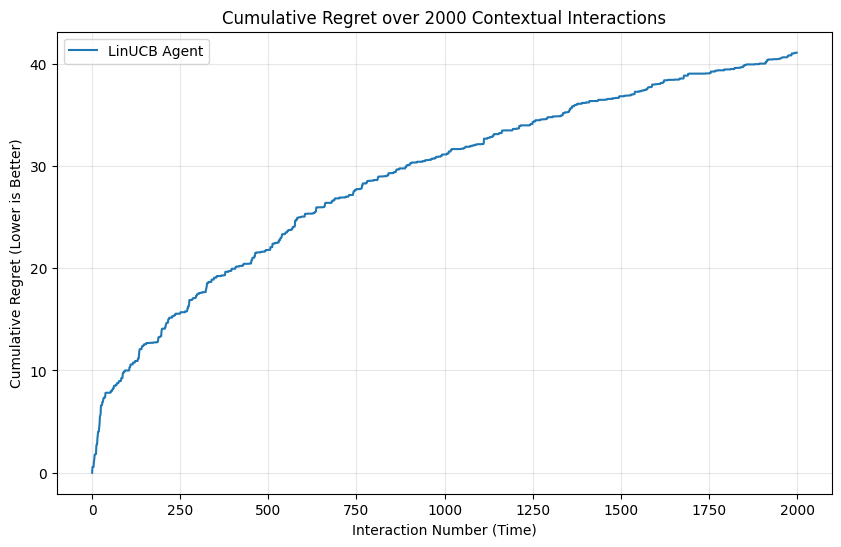

In [5]:
cumulative_regret = np.cumsum(regret_history)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret, label='LinUCB Agent')
plt.title(f'Cumulative Regret over {N_TRIALS} Contextual Interactions')
plt.xlabel('Interaction Number (Time)')
plt.ylabel('Cumulative Regret (Lower is Better)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

"While this simulation assumes stationary user preferences, future iterations could implement a Sliding Window LinUCB to account for concept drift (e.g., a user's schedule changing during weekends or holidays), which is critical for long-term health interventions."